##Labdata churn challenge

Você trabalha em uma empresa de telecomunicações e a sua tarefa, através de modelos de machine learning, é prever se um cliente irá cancelar a sua assinatura. Além disso, você deve encontrar as melhores variáveis explicativas e como elas explicam as previsões do modelo.

Cada linha representa um cliente e cada coluna representa uma informação a respeito daquele cliente. Os dados incluem os seguintes grupos de variáveis:

*    **Churn:** diz se um cliente cancelou ou não os serviços contratados
*    **Serviços que cada cliente contratou:** phone, multiple lines, internet, online security, online backup, device protection, tech support, streaming TV e streaming movies
*    **Informações a respeito da conta do cliente:** tenure, contract, payment method, paperless billing, monthly charges, and total charges
*    **Informações demográficas:** gender, age range, partners e dependents

Fonte: https://www.kaggle.com/competitions/labdata-churn-challenge-2020

#Initial imports

In [230]:
%pip install ipython-autotime
%pip install -U scikit-learn

In [231]:
from google.colab import drive, files

import numpy as np
import pandas as pd
import warnings

drive.mount('/content/drive')
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [232]:
dataset = pd.read_csv('/content/drive/MyDrive/datasets/labdata-churn-challenge-2020/train.csv', encoding='utf-8')

#EDA

In [233]:
dataset.head(5)

,id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,4030,Female,0,No,No,56.0,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,Two year,No,NaN,45.05,2560.1,0
1,6731,Male,0,Yes,Yes,NaN,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.65,332.65,0
2,6479,Female,0,Yes,No,60.0,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),110.80,6640.7,0
3,6861,Female,0,No,No,37.0,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),101.90,3545.35,1
4,3266,Male,0,Yes,Yes,29.0,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.75,1974.8,1


In [234]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634 entries, 0 to 5633
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                5634 non-null   int64  
 1   gender            5634 non-null   object 
 2   SeniorCitizen     5634 non-null   int64  
 3   Partner           5634 non-null   object 
 4   Dependents        5416 non-null   object 
 5   tenure            5173 non-null   float64
 6   PhoneService      5634 non-null   object 
 7   MultipleLines     5634 non-null   object 
 8   InternetService   5634 non-null   object 
 9   OnlineSecurity    5634 non-null   object 
 10  OnlineBackup      5634 non-null   object 
 11  DeviceProtection  5634 non-null   object 
 12  TechSupport       5634 non-null   object 
 13  StreamingTV       5634 non-null   object 
 14  StreamingMovies   5634 non-null   object 
 15  Contract          5634 non-null   object 
 16  PaperlessBilling  5634 non-null   object 


**Tipos de variáveis identificadas**

* **Binárias:** SeniorCitizen, Partner, Dependents, PhoneService, PaperlessBilling, Churn(label)

* **Qualitativas nominais:** gender, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaymentMethod

* **Qualitativas ordinais:**

* **Quantitativas contínuas:** MonthlyCharges,	TotalCharges

* **Quantitativas discretas:** tenure

**Obs.** Os nomes dos atributos são bem confusos em relação a letras maiúsculas e minúsculas. Para evitar stress vou converter todas para minúsculo.

In [235]:
columns_original = list(dataset.columns)
columns_lower = list(map(lambda x: x.lower(), columns_original))
columns_new = {key: value for (key, value) in zip(columns_original, columns_lower)}
dataset.rename(columns=columns_new, inplace=True)

Vou remover o atributo 'id' pois obviamente ele não ajudará nenhum modelo.

In [236]:
dataset = dataset.drop('id', axis=1)

Vou identificar quais atributos são categóricos e quais são numéricos. Farei algumas conversões de tipo primeiro para faciliar o entendimento das visualizações. Mas o correto é que sejam feitas na fase de engenharia de atributos.

In [237]:
dataset['churn']         = dataset['churn'].replace(0, 'No', regex=True)
dataset['churn']         = dataset['churn'].replace(1, 'Yes', regex=True)
dataset['seniorcitizen'] = dataset['seniorcitizen'].replace(0, 'No', regex=True)
dataset['seniorcitizen'] = dataset['seniorcitizen'].replace(1, 'Yes', regex=True)
dataset['totalcharges']  = dataset['totalcharges'].replace(' ', np.nan, regex=True)

dataset['churn']         = dataset['churn'].astype(str)
dataset['seniorcitizen'] = dataset['seniorcitizen'].astype(str)
dataset['totalcharges']  = dataset['totalcharges'].astype(np.float64)

fname_numerical   = dataset.select_dtypes(include=['float64','int64'])
fname_categorical = dataset.select_dtypes(include=['object'])
fname_numerical   = list(fname_numerical.columns)
fname_categorical = list(fname_categorical.columns)
fname_binary      = ['seniorcitizen', 'partner', 'dependents', 'phoneservice', 'paperlessbilling']
fname_nominal     = ['gender', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
                     'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paymentmethod']
label_name = 'churn'

fname_categorical.remove('churn')

print(f'numerical:   {fname_numerical}')
print(f'categorical: {fname_categorical}')
print(f'binary: {fname_binary}')
print(f'nominal: {fname_nominal}')
print(f'label: {label_name}')

numerical:   ['tenure', 'monthlycharges', 'totalcharges']
categorical: ['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod']
binary: ['seniorcitizen', 'partner', 'dependents', 'phoneservice', 'paperlessbilling']
nominal: ['gender', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paymentmethod']
label: churn


In [238]:
dataset[fname_numerical].describe()

,tenure,monthlycharges,totalcharges
count,5173.000000,5634.000000,5626.000000
mean,32.332882,64.626438,2273.513811
std,24.463607,30.021806,2258.383946
min,0.000000,18.250000,18.800000
25%,9.000000,35.462500,401.587500
50%,29.000000,70.250000,1396.125000
75%,55.000000,89.800000,3764.287500
max,72.000000,118.750000,8684.800000


Lista a quantidade de registros vazios em cada atributo

In [239]:
dataset.isna().sum().to_frame('number of null values')

,number of null values
gender,0
seniorcitizen,0
partner,0
dependents,218
tenure,461
phoneservice,0
multiplelines,0
internetservice,0
onlinesecurity,0
onlinebackup,0


Mostra a quantidade de classes que cada atributo categórico possui.

In [240]:
for feat_name in dataset[fname_categorical]:
  print(f'{feat_name}: {dataset[feat_name].nunique():->10} labels')

gender: ---------2 labels
seniorcitizen: ---------2 labels
partner: ---------2 labels
dependents: ---------2 labels
phoneservice: ---------2 labels
multiplelines: ---------3 labels
internetservice: ---------3 labels
onlinesecurity: ---------3 labels
onlinebackup: ---------3 labels
deviceprotection: ---------3 labels
techsupport: ---------3 labels
streamingtv: ---------3 labels
streamingmovies: ---------3 labels
contract: ---------3 labels
paperlessbilling: ---------2 labels
paymentmethod: ---------4 labels


##Data visualization

In [241]:
import matplotlib.pyplot as plt
import seaborn as sns
colors = sns.color_palette()

###Label

Vou verificar visualmente a proporção de classes da label.

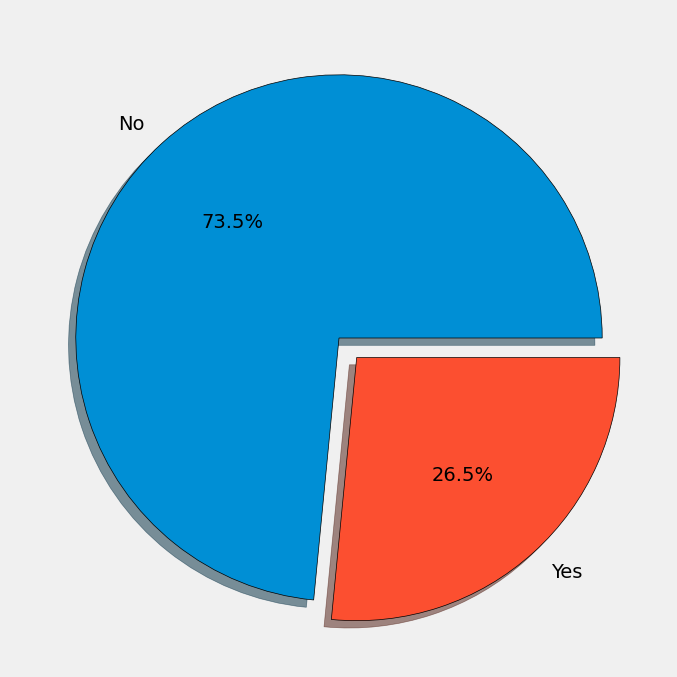

In [242]:
classes = dataset[label_name].value_counts(dropna=False).to_frame('amount')
slices = classes.to_numpy().ravel()
labels = classes.index.to_list()
explode = [0, 0.1]
plt.style.use("fivethirtyeight")
plt.figure(figsize=(7, 7))
plt.pie(slices, labels=labels, wedgeprops={'edgecolor': 'black'}, explode=explode, autopct='%1.1f%%', shadow=True)
plt.tight_layout()
plt.show()

Há um grande desequilíbrio de classes por isso não posso confiar na métrica 'acurácia' já que ela relaciona a quantidade de sucessos com a quantidade de tentativas. Essa métrica acaba se tornano imprecisa pois o 'sucesso' envolve acerto de classes, não importa qual, e basta eu criar um modelo que chute sempre a classe majoritária que ele terá, no mínimo, 73.5% de acurária. Desse modo, considerarei reequilibrar o conjunto de dados ou usar 'precisão/sensibilidade' e treinar o modelo dando atenção a isso.

###Categorical features

Vou criar vários histogramas com os atributos categóricos. A ideia é, para cada atributo e suas classes, visualizar as quantidades destas entre os clientes que cancelam a assinatura e os que não cancelam afim de traçar um perfil de cada. Além disso, vou dividir essas visualizações em dois por causa do dimensinamento dos gráficos.

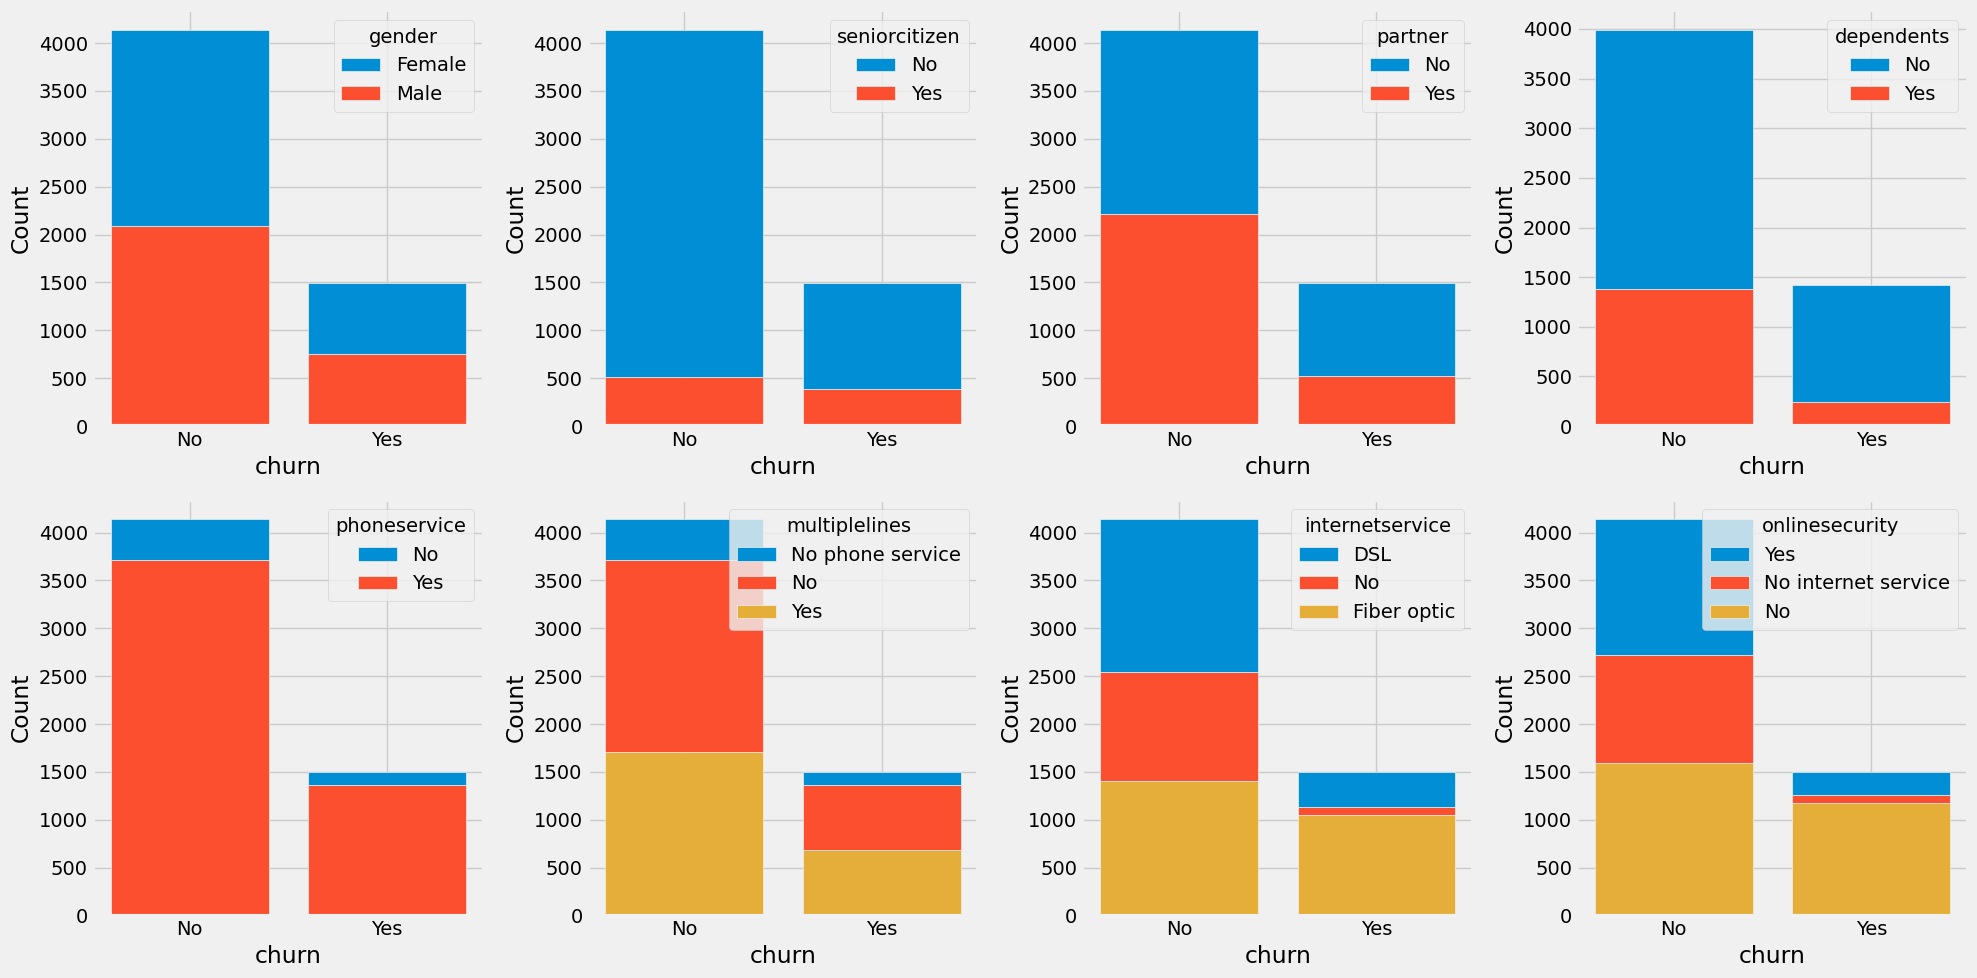

In [243]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for feature, axis in zip(dataset[fname_categorical[:8]], ax.ravel()):
  sns.histplot(data=dataset, x=label_name, hue=feature, alpha=1.0, multiple='stack', shrink=0.8, ax=axis)
plt.tight_layout()
plt.show()

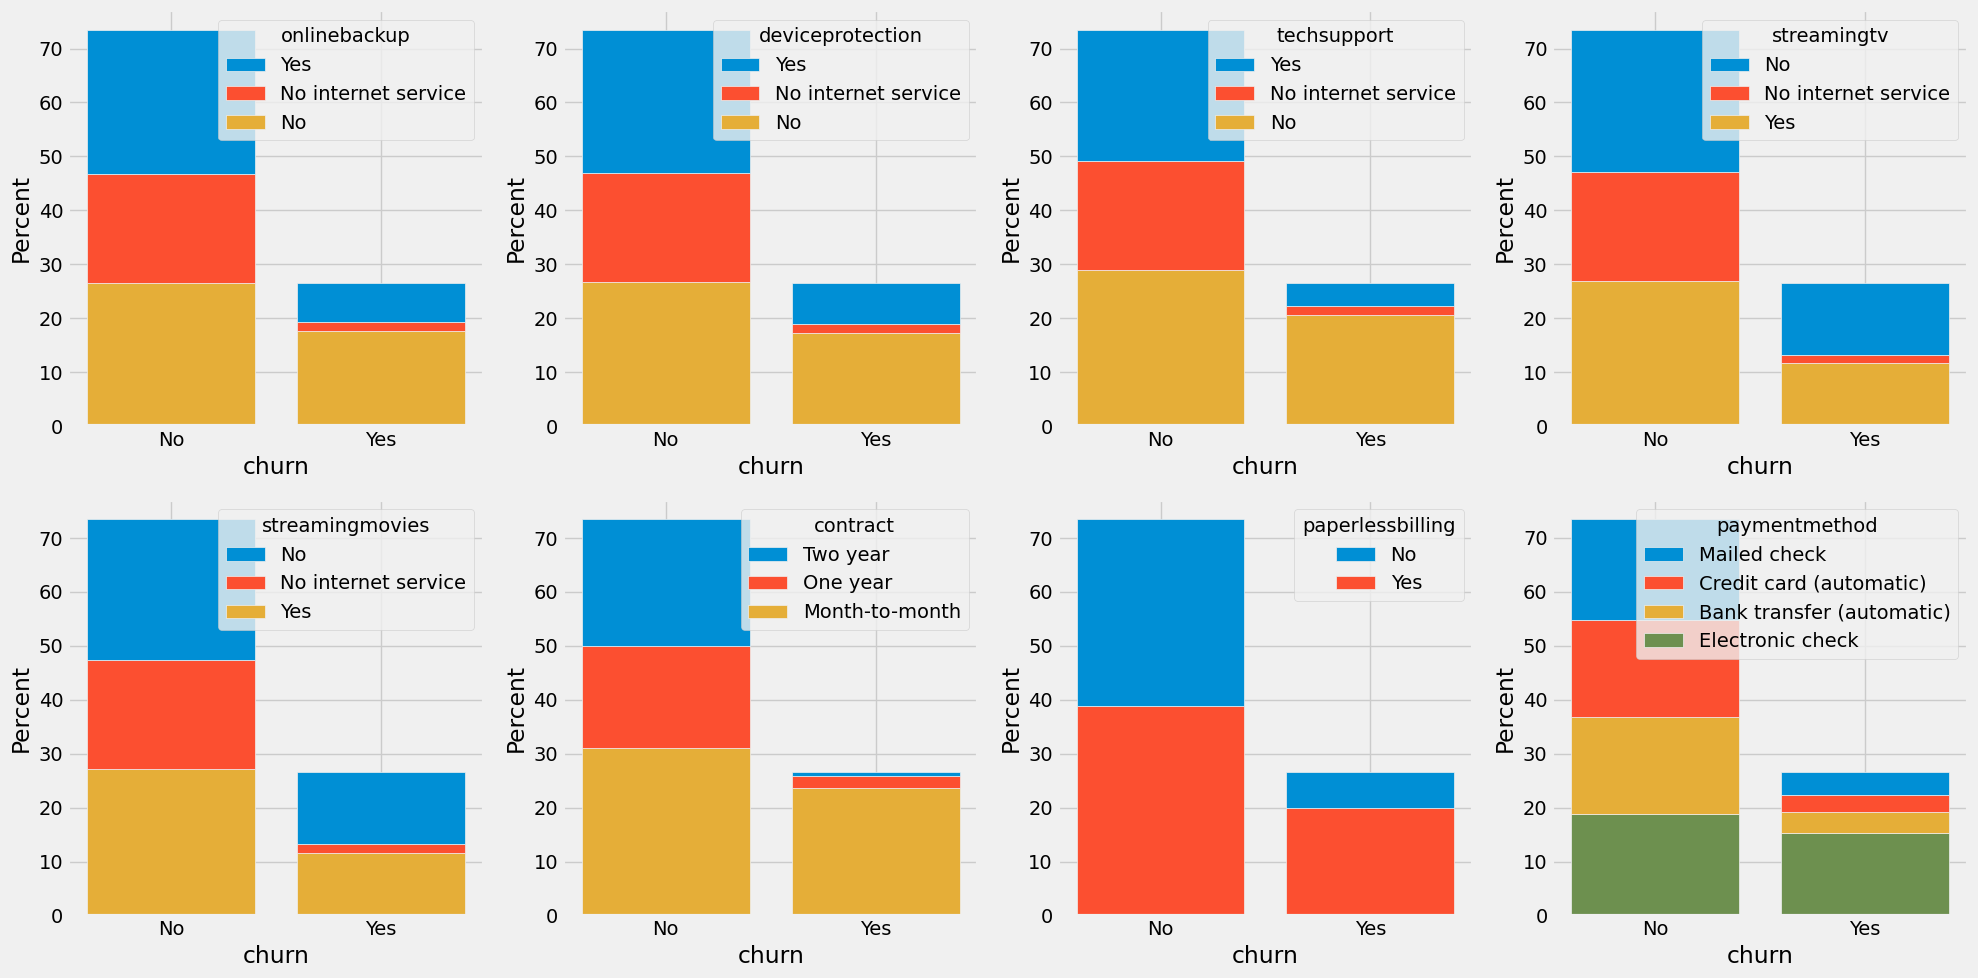

In [244]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for feature, axis in zip(dataset[fname_categorical[8:]], ax.ravel()):
  sns.histplot(data=dataset, x=label_name, hue=feature, stat='percent', alpha=1.0, multiple='stack', shrink=0.8, ax=axis)
plt.tight_layout()
plt.show()

Com esses gráficos podemos obter algumas informações úteis. Vou dividir em dois segmentos, aqueles que cancelaram os serviços da empresa e aqueles que permaneceram.

*   **Cancelaram:**
    *   **internetservice:** Maioria possui fibra óptica em relação a 'No' e 'DSL'.
    *   **onlinesecurity:** Maioria não possui.
    *   **onlinebackup:** Maioria não possui.
    *   **deviceprotection:** Maioria não possui.
    *   **techsupport:** Maioria não possui.
    *   **contract:** Maioria possui contrato 'Month-to-Month'.
    *   **paperlessbilling:** Maioria 'Yes'.
    *   **paymentmethod:** Maioria escolhe 'Electronic Check'.

*   **Não cancelaram:**
    *   **internetservice:** Distribuição de classes é semelhante.
    *   **onlinesecurity:** Distribuição de classes é semelhante.
    *   **onlinebackup:** Distribuição de classes é semelhante.
    *   **deviceprotection:** Distribuição de classes é semelhante.
    *   **techsupport:** Distribuição de classes é semelhante.
    *   **contract:** Distribuição de classes é semelhante.
    *   **paperlessbilling:** Distribuição de classes é semelhante.
    *   **paymentmethod:** Distribuição de classes é semelhante.

Desconfio que as classes 'No phone service' e 'No internet service' presentes em vários atributos são ruídos, pois já existem dois atributos que dizem exatamente a mesma coisa.

**Dependentes:** Este atributo possui valores nulos e para imputação posso adotar uma estratégia mais interessante do que apenas usar a moda dele. Tenho duas teorias que se forem corretas posso escolher para essa tarefa na fase de feature engineering. Mas, primeiro preciso testá-las com a ajuda de visualização de dados.

* **Teoria 01:** Pessoas que têm múltiplas linhas tendem a ter dependentes e pessoas que têm apenas uma linha, não. São pessoas solteiras, quem sabe, e tendem a ter apenas uma linha.

In [245]:
mask   = dataset['multiplelines'] == 'No'
ml_no  = dataset.loc[mask, 'dependents'].value_counts()

mask   = dataset['multiplelines'] == 'Yes'
ml_yes = dataset.loc[mask, 'dependents'].value_counts()

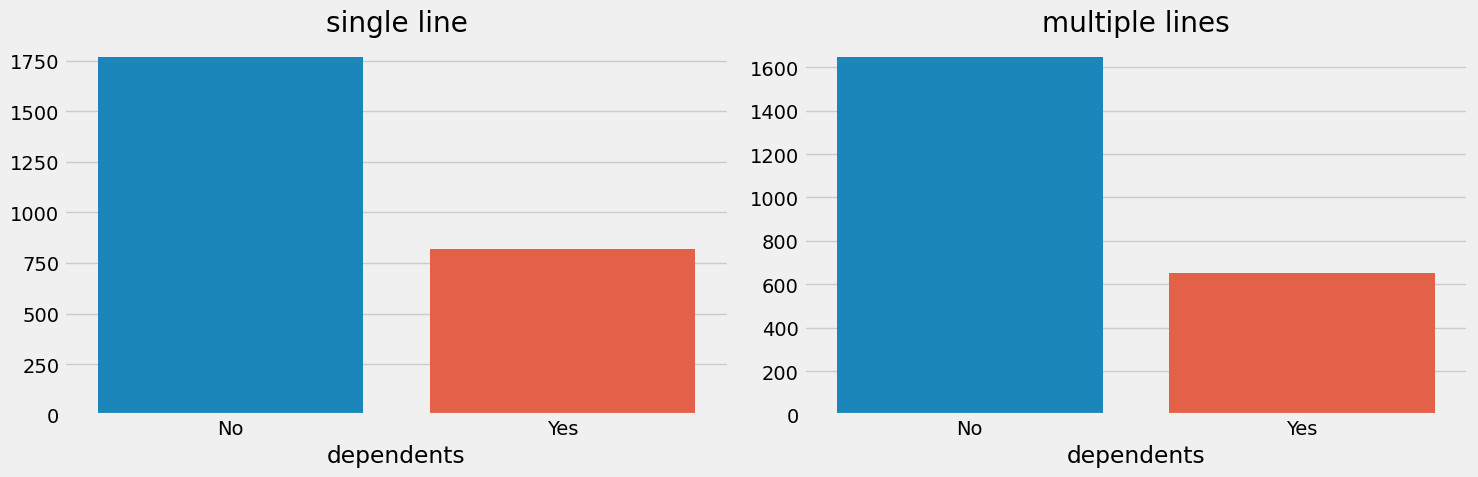

In [246]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax = ax.ravel()
ax[0].set_title('single line')
ax[1].set_title('multiple lines')
ax[0].set(xlabel='dependents')
ax[1].set(xlabel='dependents')
sns.barplot(x=ml_no.index, y=ml_no.values, ax=ax[0])
sns.barplot(x=ml_yes.index, y=ml_yes.values, ax=ax[1])
plt.tight_layout()
plt.show()

**Conclusão:** Não deu certo! Tanto pessoas com uma única linha quanto pessoas com múltiplas, tendem não ter dependentes. Isso significa que não posso usar 'multiplelines' para imputar valores em 'dependents'.

* **Teoria 02:** Pessoas idosas e com parceiros tendem a ter dependentes e jovens sem parceiros, não. Essa estratégia não vai preencher todos os campos NaN, mas como disse antes, é melhor do que adotar a moda como estratégia de imputação.

In [247]:
mask   = dataset['seniorcitizen'] == 'No'
young  = dataset.loc[mask, :]
mask   = dataset['seniorcitizen'] == 'Yes'
senior = dataset.loc[mask, :]

# Estou mais interessado nas proporções do que nos valores absolutos
prop_young  = young['dependents'].value_counts() / young.shape[0]
prop_senior = senior['dependents'].value_counts() / senior.shape[0]

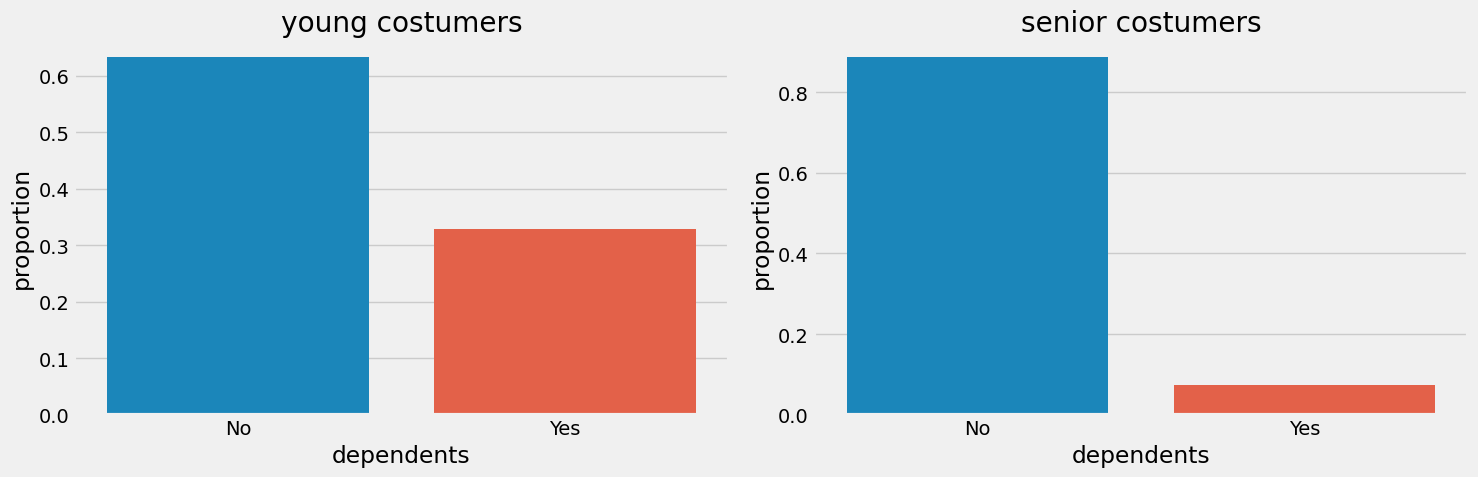

In [248]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax = ax.ravel()
sns.barplot(x=prop_young.index,  y=prop_young.values,  ax=ax[0])
sns.barplot(x=prop_senior.index, y=prop_senior.values, ax=ax[1])
ax[0].set_title('young costumers')
ax[1].set_title('senior costumers')
ax[0].set(xlabel='dependents', ylabel='proportion')
ax[1].set(xlabel='dependents', ylabel='proportion')
plt.tight_layout()
plt.show()

**Conlcusão:** Ok! Achei que a maioria dos idosos teriam dependentes, mas os dados mostram exatamente o contrário. Quem ssabe seja porque idosos, se tiverem filhos, são adultos e portanto não são mais dependentes. O importanque é que isso ajuda a imputar valores NaN em 'dependents' quando o usuário for idoso. Basta eu atribuir sempre 'No' que estarei certo mais de 80% das vezes.

Agora, vou focar apenas nos jovens. Este caso é mais complicado! Quem sabe se eu for um pouco mais específico utilizando mais um atributo eu consiga resultados melhores. Portanto, vou selecionar jovens com e sem parceiros para ver qual a propoção destes que têm ou não dependentes.

In [249]:
mask = young['partner'] == 'No'
young_no_partner = young[mask]
mask = young['partner'] == 'Yes'
young_yes_partner = young[mask]

prop_young_no_partner  = young_no_partner['dependents'].value_counts() / young_no_partner.shape[0]
prop_young_yes_partner = young_yes_partner['dependents'].value_counts() / young_yes_partner.shape[0]

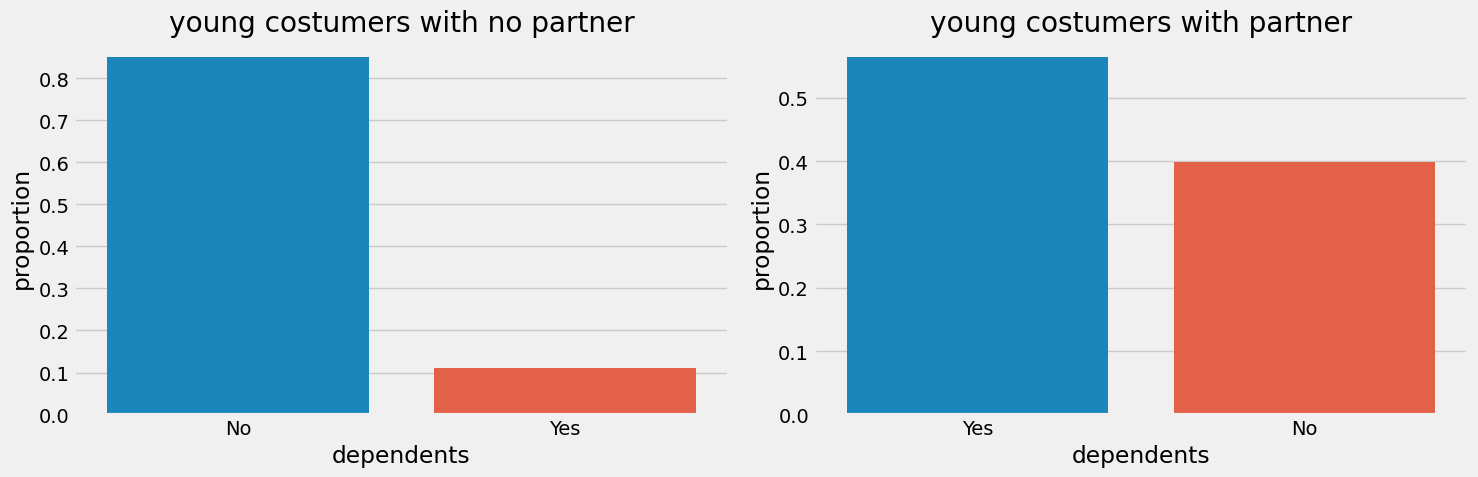

In [250]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax = ax.ravel()
sns.barplot(x=prop_young_no_partner.index,  y=prop_young_no_partner.values,  ax=ax[0])
sns.barplot(x=prop_young_yes_partner .index, y=prop_young_yes_partner .values, ax=ax[1])
ax[0].set_title('young costumers with no partner')
ax[1].set_title('young costumers with partner')
ax[0].set(xlabel='dependents', ylabel='proportion')
ax[1].set(xlabel='dependents', ylabel='proportion')
plt.tight_layout()
plt.show()

**Conclusão:** Como visto no gráfico anterior a este, praticamente o dobro dos clientes que são jovens não têm dependentes em relação aqueles que têm. Mas, se eu filtrar ainda mais entre os que têm ou não parceiros, eu consigo ser ainda mais preciso porque mais de 80% dos que são solteiros não têm dependentes.

Portanto, a estratégia será: Se for idoso ou jovem solteiro, será imputado o valor 'No'. Caso contrário, 'Yes'.

---

###Numerical features

Criarei o mesmo tipo de gráfico com os atributos numéricos. A ideia é comparar os **valores médios** de cada um deles entre aqueles que cancelaram o serviço e os que mantiveram suas assinaturas.

In [251]:
dataset[fname_numerical].describe()

,tenure,monthlycharges,totalcharges
count,5173.000000,5634.000000,5626.000000
mean,32.332882,64.626438,2273.513811
std,24.463607,30.021806,2258.383946
min,0.000000,18.250000,18.800000
25%,9.000000,35.462500,401.587500
50%,29.000000,70.250000,1396.125000
75%,55.000000,89.800000,3764.287500
max,72.000000,118.750000,8684.800000


In [252]:
mask = (dataset[label_name] == 'No')
ds_negative = dataset[mask]

mask = (dataset[label_name] == 'Yes')
ds_positive = dataset[mask]

neg = ds_negative[fname_numerical].describe()
pos = ds_positive[fname_numerical].describe()
monthly_charges_mean = {'No': neg.loc['mean', 'monthlycharges'], 'Yes': pos.loc['mean', 'monthlycharges']}
total_charges_mean   = {'No': neg.loc['mean', 'totalcharges'], 'Yes': pos.loc['mean', 'totalcharges']}
tenure_mean          = {'No': neg.loc['mean', 'tenure'], 'Yes': pos.loc['mean', 'tenure']}
monthly_charges_mean = pd.Series(data=monthly_charges_mean, name='monthly_charges_mean')
total_charges_mean   = pd.Series(data=total_charges_mean, name='total_charges_mean')
tenure_mean          = pd.Series(data=tenure_mean, name='tenure_mean')

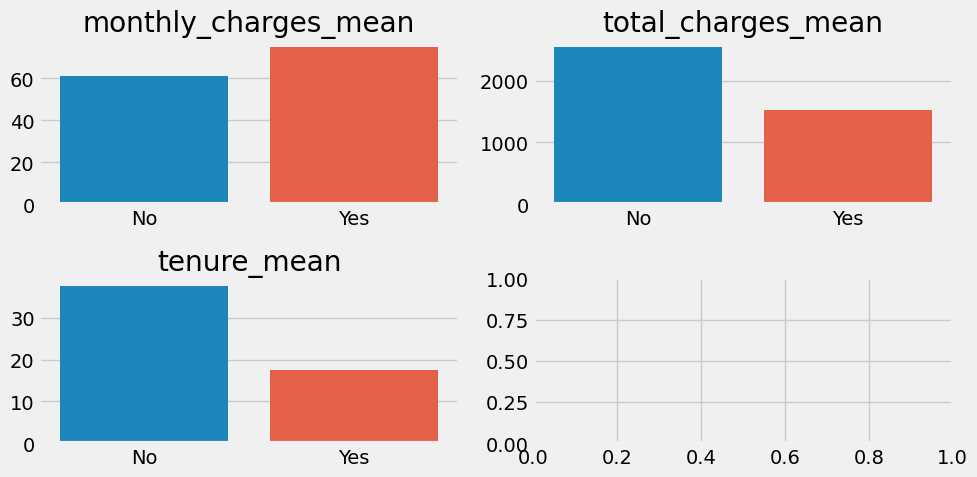

In [253]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax = ax.ravel()
ax[0].set_title(monthly_charges_mean.name)
ax[1].set_title(total_charges_mean.name)
ax[2].set_title(tenure_mean.name)
sns.barplot(x=monthly_charges_mean.index, y=monthly_charges_mean.values, ax=ax[0])
sns.barplot(x=total_charges_mean.index, y=total_charges_mean.values, ax=ax[1])
sns.barplot(x=tenure_mean.index, y=tenure_mean.values, ax=ax[2])
plt.tight_layout()
plt.show()

Com esses gráficos podemos obter algumas informações úteis.

*   **tenure:** Pessoas que cancelam suas assinaturas permanecem menos mêses com o serviço do que aquelas que não cancelam.
*   **totalcharges:** Justamente por ficarem menos tempo elas tem um gasto total menor.
*   **monthlycharges:** Os gastos mensais daqueles que cancelaram suas assinaturas são maiores do que aqueles que permaneceram.


#Train/Test split

In [254]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing   import OrdinalEncoder

Antes de fazer qualquer alteração no conjunto de dados e principalmente treinar modelos, preciso fazer a separação do conjunto em treinamento e teste. Este processo ajuda a evitar overfitting do modelo. Vou levar em conta o desequilíbrio de classes por isso farei uma amostragem estratificada.

Além disso, vou codificar antecipadamente a label pois, no pipeline de transformações, vou precisar que ela esteja codificada para o uso do TargetEncoder. Para isso, vou usar OrdinalEncoder que vai atribuir valor 0 para 'No' e 1 para 'Yes', mas sem aumentar a dimensionalidade, como BinaryEncoder faz. Para atributos binários, OrdinalEncoder pode ser usado pois só vai produzir [0, 1].

In [255]:
X = dataset.iloc[:, :-1]
y = dataset[label_name]
y = OrdinalEncoder().fit_transform(y.to_numpy().reshape(-1, 1))
y = pd.Series(data=y.ravel())

# vou substitui a label antiga pela nova, codificada
dataset[label_name] = y

In [256]:
skf = StratifiedKFold()
result = skf.split(X, y)
train_indexes, test_indexes = next(result) # só o primeiro fold me interessa

train_set = dataset.iloc[train_indexes, :]
test_set  = dataset.iloc[test_indexes, :]

# o atributo 'id' é claramente irrelevante para fazer a análise de churn
train_set = train_set.reset_index().drop('index', axis=1)
test_set  = test_set.reset_index().drop('index', axis=1)

#Feature engineering

In [257]:
%pip install category-encoders

In [258]:
from category_encoders       import TargetEncoder
from scipy.stats             import zscore
from sklearn.base            import BaseEstimator, TransformerMixin
from sklearn.compose         import ColumnTransformer
from sklearn.impute          import SimpleImputer
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler

A classe ColumnTransformer retorna por padrão um numpy array, mas para gerenciar melhor os atributos que passarão por transformações através de um pipeline, prefiro que ela retorne sempre um objeto DataFrame do Pandas. O problema é que este vem com os nomes das colunas alterados, então resolvi criar a classe abaixo para atribuir ao DataFrame que saiu do ColumnTransformer os nomes originais.

In [259]:
class FeaturesRenamer(BaseEstimator, TransformerMixin):
    """
    Esta classe deve ser colocada diretamente dentro de um Pipeline.
    Quando 'get_feature_names_out()' é chamado ele concatena o nome do transformador ao nome de cada coluna
    que passará pela transformação. Esta classe desfaz isso retornando os nomes originais.
    """
    def __init__(self, original_names):
        if isinstance(original_names, list):
            self.original_names = original_names
        else:
            self.original_names = list(original_names)
    def fit(self, X, y=None):
        return self
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)
    def transform(self, X, y=None):
        new_names = list()
        for name in list(X.columns):
            for original in self.original_names:
                if name.endswith('__' + original):
                    new_names.append(original)
        return X.set_axis(new_names, axis=1)

##Categorical features

**Etapa ##: Nan values:** Imputação

In [260]:
class DependentsImputer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def transform(self, X, y=None):
    # se for idoso ou jovem solteiro
    mask_imputer    = (X['seniorcitizen'] == 'Yes') | ((X['seniorcitizen'] == 'No') & (X['partner'] == 'No'))
    mask_dependents = (X['dependents'].isna())
    mask_no_dependents  = (mask_imputer & mask_dependents)
    mask_yes_dependents = (~mask_imputer & mask_dependents)
    X.loc[mask_no_dependents, 'dependents']  = 'No'
    X.loc[mask_yes_dependents, 'dependents'] = 'Yes'
    return X

  def get_feature_names_out(self):
      pass

In [261]:
tcat_si = ColumnTransformer(transformers=[('simple_imputer', SimpleImputer(strategy='most_frequent'), ['paymentmethod']),
                                          ('dependents_imputer', DependentsImputer(), ['dependents', 'seniorcitizen', 'partner'])],
                            remainder='passthrough')
tcat_si.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('simple_imputer',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['paymentmethod']),
                                ('dependents_imputer', DependentsImputer(),
                                 ['dependents', 'seniorcitizen', 'partner'])])

**Etapa ##: Atributos binários: Codificação:** Vou usar OrdinalEncoder nos atributos binários pelo mesmo motivo que usei na label.

In [262]:
tcat_bn = ColumnTransformer(transformers=[('binary_encoder', OrdinalEncoder(), fname_binary)], remainder='passthrough')
tcat_bn.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('binary_encoder', OrdinalEncoder(),
                                 ['seniorcitizen', 'partner', 'dependents',
                                  'phoneservice', 'paperlessbilling'])])

**Etapa ##: Atributos nominais: Codificação:** Vou usar TargetEncoder pois, pelo seu funcionamento, vai atribuir um significado aos atributos nominais. Melhor do que fazer uma atribuição aleatória de valor a cada classe de um atributo.

Funcionamento do target encoder: https://contrib.scikit-learn.org/category_encoders/targetencoder.html

In [263]:
tcat_te = ColumnTransformer(transformers=[('target_encoder', TargetEncoder(), fname_nominal)], remainder='passthrough')
tcat_te.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('target_encoder', TargetEncoder(),
                                 ['gender', 'multiplelines', 'internetservice',
                                  'onlinesecurity', 'onlinebackup',
                                  'deviceprotection', 'techsupport',
                                  'streamingtv', 'streamingmovies', 'contract',
                                  'paymentmethod'])])

**Etapa final: Pipeline Categórico**

In [264]:
steps = [('simple_imputer',  tcat_si),
         ('renamer01',    FeaturesRenamer(train_set.columns)),
         ('binary_encoder', tcat_bn),
         ('renamer02',    FeaturesRenamer(train_set.columns)),
         ('target_encoder',  tcat_te),
         ('renamer03',    FeaturesRenamer(train_set.columns)),]

pipeline_cat = Pipeline(steps=steps)

##Numerical features

**Etapa ##: Nan values:** Imputação

No caso de 'totalcharges', prefiro usar SimpleImputer com a mediana como estratégia porque ela não é afetada por outliers.

In [265]:
tnum_si = ColumnTransformer(transformers=[('simple_imputer', SimpleImputer(strategy='median'), ['totalcharges'])], remainder='passthrough')
tnum_si.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('simple_imputer',
                                 SimpleImputer(strategy='median'),
                                 ['totalcharges'])])

Os campos NaN de 'tenure' podem ser imputados de uma forma mais inteligente do que simplesmente usar a média ou mediana. Há outros dois atributos que podem me ajudar a realizar essa tarefa, 'totalcharges' e 'monthlycharges'. Basta divir um pelo outro e obtenho o número de meses que um cliente está pagando. Vou encapsular essa imputação em uma classe para poder colocá-la em um pipeline.

In [266]:
class TenureImputer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self
  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)
  def transform(self, X, y=None):
    boolean_mask = X['tenure'].isna()
    X.loc[boolean_mask, 'tenure'] = round(X['totalcharges'] / X['monthlycharges'])
    return X
  def get_feature_names_out(self):
    pass



ct_tenureimputer = ColumnTransformer(transformers=[('tenure_imputer', TenureImputer(), ['tenure', 'totalcharges', 'monthlycharges'])],
                                     remainder='passthrough')
ct_tenureimputer.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('tenure_imputer', TenureImputer(),
                                 ['tenure', 'totalcharges', 'monthlycharges'])])

**Etapa ##: Outliers:** Identificação e substituição pela mediana.

In [267]:
class OutliersZScoreReplacer(BaseEstimator, TransformerMixin):
    """
    Substitui os outliers encontrados pelas medianas de cada atributo.
    """
    def fit(self, X, y=None):
        self.mean_std_median = list()
        for name in X.columns:
            mean   = X[name].mean()
            std    = X[name].std()
            median = X[name].median()
            self.mean_std_median.append((mean, std, median))
        return self
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)
    def transform(self, X, y=None):
        std_unit = 3
        for index, name in enumerate(X.columns):
            mean    = self.mean_std_median[index][0]
            std     = self.mean_std_median[index][1]
            median  = self.mean_std_median[index][2]
            scores  = ((X[name] - mean) / std)
            filter_mask = ((scores < -std_unit) | (scores > std_unit))
            X.loc[filter_mask, name] = median
        return X
    def get_feature_names_out(self):
        pass



ct_outliers = ColumnTransformer(transformers=[('outliers_replacer', OutliersZScoreReplacer(), fname_numerical)], remainder='passthrough')
ct_outliers.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('outliers_replacer', OutliersZScoreReplacer(),
                                 ['tenure', 'monthlycharges', 'totalcharges'])])

**Etapa final: Pipeline Numérico**

In [268]:
steps = [('simple_imputer',   tnum_si),
         ('renamer01',        FeaturesRenamer(train_set.columns)),
         ('tenure_imputer',   ct_tenureimputer),
         ('renamer02',        FeaturesRenamer(train_set.columns)),
         ('outliers_remover', ct_outliers),
         ('renamer03',        FeaturesRenamer(train_set.columns))]

pipeline_num = Pipeline(steps=steps)

##Full pipeline

**Etapa ##: Padronizador**: Vou padronizar todos os atributos, por isso vou adicionar esse transformador diretamente ao pipeline final.

In [269]:
cols_names = fname_categorical + fname_numerical

tfull_ss = ColumnTransformer(transformers=[('standard_scaler', StandardScaler(), cols_names)], remainder='passthrough')
tfull_ss.set_output(transform='pandas')

pipeline_std = Pipeline(steps=[('stdardization', tfull_ss),
                               ('renamer', FeaturesRenamer(train_set.columns))])

Farei uma copia do conjunto de treinamento sem qualquer transformação para ser usado na validação cruzada personalizada que criarei.

In [270]:
train_set_cv = train_set.copy()

In [271]:
full_steps = [('categorical',   pipeline_cat),
              ('numerical',     pipeline_num),
              ('stdardization', pipeline_std),]

full_pipeline = Pipeline(steps=full_steps)
train_set = full_pipeline.fit_transform(train_set, train_set[label_name])
test_set  = full_pipeline.transform(test_set)

In [272]:
y_train = train_set[label_name]
y_test  = test_set[label_name]

X_train = train_set.drop(label_name, axis=1)
X_test = test_set.drop(label_name, axis=1)

#Resample

Decidi não reequilibrar o conjunto de dados com oversample ou undersample, mas adotar outra estratégia. Nos modelos que fornecerem o atributo 'class_weight' vou definir o mesmo peso para ambas as classes de 'churn'.

#Model training

Antes de qualquer escolha de modelos ou métricas é preciso pensarmos um pouco a respeito do impacto dos falsos positivos e negativos.

*   Falsos positivos são aceitáveis? Dependendo da estratégia da empresa para obter uma retenção de usuários maior, sim, é aceitável.
    * O custo desse erro é alto? Acredito que seja o que vai definir se falsos positivos são aceitáveis ou não. Oferecer pacotes de canais de streaming adicionais para usuário que não pretendiam sair não é tão ruim. Isso porque se não houver custo adicional para empresa, o pior que acontecerá será ela deixar de ganhar, ou seja, reduzir o seu faturamento, proporcionalmente à quantidade de falsos positivos. Caso o usuário cancele sua assintura o prejuízo é bem maior.


Este modelo precisa ter a melhor precisão possível em conjunto com sensibilidade. Assim, a primeira etapa é escolher modelos candidatos. Vou testar dois lineares e dois baseados em árvores de decisões. O teste será feito através da minha função custom_cross_validation() que usará a métrica personalizada AUPRC. Os dois modelos com maior pontuação(um de cada categoria) serão eleitos para tunagem de hiperparâmetros. Um critério de desempate será a complexidade do modelo. O mais simples leva vantagem.

In [273]:
from lightgbm                   import LGBMClassifier
from sklearn.base               import clone
from sklearn.dummy              import DummyClassifier
from sklearn.ensemble           import RandomForestClassifier
from sklearn.linear_model       import LinearRegression, LogisticRegression
from sklearn.metrics            import auc, classification_report, confusion_matrix, make_scorer, precision_recall_curve, precision_score, recall_score
from sklearn.model_selection    import cross_val_predict, RandomizedSearchCV
from sklearn.svm                import SVC
from sklearn.utils.class_weight import compute_class_weight

##Custom functions

###Confusion matrix visualization

In [274]:
def show_confusion_matrix(confusion_matrix):
  cm_matrix = pd.DataFrame(data=confusion_matrix, columns=['Predict Negative:0', 'Predict Positive:1'],
                           index=['Actual Negative:0', 'Actual Positive:1'])
  fig, ax = plt.subplots()
  ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
  sns.heatmap(cm_matrix/np.sum(cm_matrix), annot=True, fmt='.2g', cmap='YlGnBu', ax=ax)
  plt.show()

###Custom metric: AUPRC

Métrica personalizada que eu vou usar no lugar de 'accuracy'. É a área de baixo da curva, mas do gráfico precision/recall. Acredito que seja mais adequada para identificar modelos com boa precisão e sensibilidade levando em conta o desequilíbrio de classes.

In [275]:
def auprc_score(y_true, y_pred):
  """
  Calcula a área de baixo da curva do gráfico precision/recall.
  """
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  auprc_score = auc(recall, precision)
  return auprc_score



auprc = make_scorer(auprc_score)

###Cross validation

Vou criar uma função de validação cruzada que evitará vazamento de informação mesmo entre os grupos de treino e validação de cada fold. Além disso, essa função garantirá que estes grupo internos preservem a proporção de classes da label.

Como o conjunto é desequilibrado, e não pretendo reequilibrá-lo, não posso confiar na sua acurácia. Também estou mais interessando que o modelo detecte melhor a classe minoritária que corresponde a quem vai cancelar a assinatura. Desse modo, vou calcular a média aritmética da precisão e sensibilidade do modelo em prever a classe positiva e negativa através dos folds.

**Obs.** Vou calcular essas métricas da classe negativa apenas para efeito de comparação porque estou mais interessado nas positivas.

In [276]:
def custom_cross_validation(model, pipe_transformers, dataset, label_name):
  skf = StratifiedKFold()
  n_splits = skf.get_n_splits(dataset, dataset[label_name])
  precision = dict()
  recall    = dict()
  auprc     = list()
  precision['No']  = 0
  precision['Yes'] = 0
  recall['No']  = 0
  recall['Yes'] = 0
  for train_indexes, valid_indexes in skf.split(dataset, dataset[label_name]):
    train_set = dataset.iloc[train_indexes, :]
    valid_set = dataset.iloc[valid_indexes, :]
    train_set = train_set.reset_index().drop('index', axis=1)
    valid_set = valid_set.reset_index().drop('index', axis=1)
    train_set = pipe_transformers.fit_transform(train_set, train_set[label_name])
    valid_set = pipe_transformers.transform(valid_set)
    y_train = train_set[label_name]
    y_valid = valid_set[label_name]
    X_train = train_set.drop(label_name, axis=1)
    X_valid = valid_set.drop(label_name, axis=1)
    model_clone = clone(model)
    model_clone.fit(X_train, y_train)
    y_pred = model_clone.predict(X_valid)
    pr     = precision_score(y_valid, y_pred, average=None)
    rc     = recall_score(y_valid, y_pred, average=None)
    precision['No']  += pr[0]
    precision['Yes'] += pr[1]
    recall['No']     += rc[0]
    recall['Yes']    += rc[1]
    auprc.append(auprc_score(y_valid, y_pred))
  print(f'Precision(No) : {(precision["No"] / n_splits):.2f}')
  print(f'Precision(Yes): {(precision["Yes"] / n_splits):.2f}')
  print(f'Recall(No) : {(recall["No"] / n_splits):.2f}')
  print(f'Recall(Yes): {(recall["Yes"] / n_splits):.2f}')
  print(f'AUPRC: {(np.sum(auprc) / n_splits):.2f}')

###Class weight estimation

In [277]:
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: weights[0], 1:weights[1]}
print(class_weights)

{0: 0.6806100875868317, 1: 1.8841973244147157}


###DummyClassifier: Baseline model
Modelo de referência. Os outros devem ter desempenho melhor do que este para serem considerados.

In [278]:
minor_class = 1
custom_cross_validation(DummyClassifier(strategy='constant', constant=minor_class), Pipeline(steps=full_steps), train_set_cv, label_name)

Precision(No) : 0.00
Precision(Yes): 0.27
Recall(No) : 0.00
Recall(Yes): 1.00
AUPRC: 0.63


###LogisticRegression

In [279]:
custom_cross_validation(LogisticRegression(class_weight=class_weights, random_state=42), Pipeline(steps=full_steps), train_set_cv, label_name)

Precision(No) : 0.91
Precision(Yes): 0.53
Recall(No) : 0.74
Recall(Yes): 0.80
AUPRC: 0.69


###SVC

In [280]:
custom_cross_validation(SVC(class_weight=class_weights, random_state=42), Pipeline(steps=full_steps), train_set_cv, label_name)

Precision(No) : 0.91
Precision(Yes): 0.53
Recall(No) : 0.74
Recall(Yes): 0.79
AUPRC: 0.69


###RandomForestClassifier

In [281]:
custom_cross_validation(RandomForestClassifier(class_weight=class_weights, random_state=42), Pipeline(steps=full_steps), train_set_cv, label_name)

Precision(No) : 0.83
Precision(Yes): 0.65
Recall(No) : 0.90
Recall(Yes): 0.50
AUPRC: 0.64


###LightGBM

In [282]:
custom_cross_validation(LGBMClassifier(class_weight=class_weights, random_state=42), Pipeline(steps=full_steps), train_set_cv, label_name)

[LightGBM] [Info] Number of positive: 957, number of negative: 2648
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 3605, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500128 -> initscore=0.000511
[LightGBM] [Info] Start training from score 0.000511
[LightGBM] [Info] Number of positive: 956, number of negative: 2649
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 3605, number of used features: 19
[LightGBM] [Info] [binar

##Best models hyperparameter optimization

###Logistic Regression

####RandomizedSearchCV

In [283]:
params = {'penalty': ['l2', 'none'],
          'C': np.arange(1.0, 5.0, 0.01),
          'l1_ratio': np.arange(0, 1, 0.01),
          'random_state': [42]}

rscv = RandomizedSearchCV(LogisticRegression(class_weight=class_weights), params, n_iter=50, cv=5, scoring=auprc, verbose=False, random_state=42)
rscv.fit(X_train, y_train)
lr_best_rsearch = rscv.best_estimator_

print(f'Best parameters are: {rscv.best_params_}\n')
y_pred = lr_best_rsearch.predict(X_train)
print(f'Test set AUPRC: {auprc_score(y_train, y_pred)}\n')
print(classification_report(y_train, y_pred))

Best parameters are: {'random_state': 42, 'penalty': 'l2', 'l1_ratio': 0.3, 'C': 1.04}

Test set AUPRC: 0.6925733753325977

              precision    recall  f1-score   support

         0.0       0.91      0.74      0.82      3311
         1.0       0.53      0.80      0.64      1196

    accuracy                           0.76      4507
   macro avg       0.72      0.77      0.73      4507
weighted avg       0.81      0.76      0.77      4507



#### Train and Test

In [284]:
lr_best_rsearch.fit(X_train, y_train)

y_pred_train = lr_best_rsearch.predict(X_train)
y_pred_test  = lr_best_rsearch.predict(X_test)

print(f'Train set AUPRC: {auprc_score(y_train, y_pred_train):.2f}')
print(f'Test set  AUPRC: {auprc_score(y_test, y_pred_test):.2f}')

Train set AUPRC: 0.69
Test set  AUPRC: 0.69


Como o resultado foi o mesmo no conjunto de treinamento e teste posso dizer que não há overfitting.

              precision    recall  f1-score   support

         0.0       0.74      1.00      0.85      3311
         1.0       0.93      0.01      0.02      1196

    accuracy                           0.74      4507
   macro avg       0.84      0.51      0.44      4507
weighted avg       0.79      0.74      0.63      4507



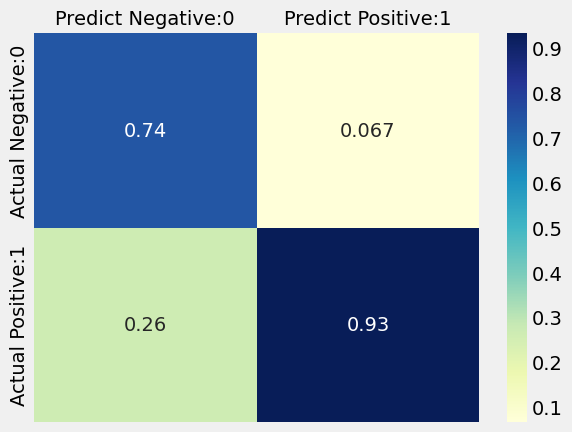

In [285]:
y_scores = lr_best_rsearch.predict_proba(X_train)
y_scores = y_scores[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

precision = 0.9
threshold_precision = thresholds[np.argmax(precisions >= precision)]
y_train_pred = (y_scores >= threshold_precision)

print(classification_report(y_train, y_train_pred))
show_confusion_matrix(confusion_matrix(y_train, y_train_pred))

De acordo com a matriz de confução acima podemos concluir que este modelo está identificando com maior precisão quem pretende cancelar a sua assinatura do que aqueles que pretendem continuar assinantes. A taxa de falsos positivos é de 6.7%, ou seja, essa é a proporção de assinantes que estão felizes com a empresa e não têm intenção sair são identificados como potenciais canceladores da assinatura. A redução de receita será proporcional a esse valor dependendo das estratégias adotadas para manter o cliente.

Daqueles que cancelaram suas assinaturas, 93% foram identificados corretamente. É possível aumentar ainda mais essa taxa, mas ao custo de mais falsos positivos.

Vejamos agora como o modelo se sai com dados que ele nunca viu.

              precision    recall  f1-score   support

         0.0       0.77      0.99      0.87       828
         1.0       0.91      0.20      0.33       299

    accuracy                           0.78      1127
   macro avg       0.84      0.60      0.60      1127
weighted avg       0.81      0.78      0.73      1127



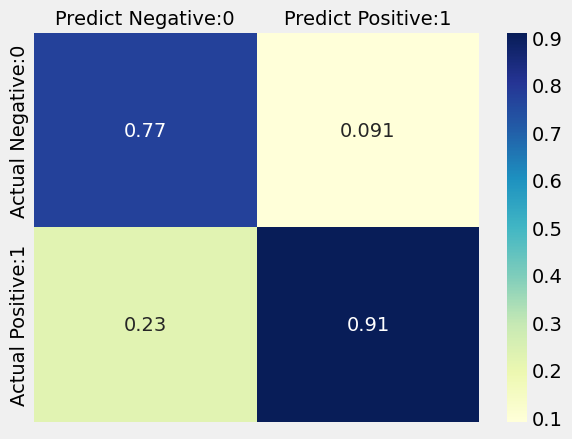

In [286]:
y_probas = lr_best_rsearch.predict_proba(X_test)
y_scores = y_probas[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

precision = 0.9
threshold_precision = thresholds[np.argmax(precisions >= precision)]
y_train_pred = (y_scores >= threshold_precision)

print(classification_report(y_test, y_train_pred))
show_confusion_matrix(confusion_matrix(y_test, y_train_pred))

Gostei, pois ele aumentou mais a taxa de verdadeiros negativos, de 74% para 77% e não diminuiu tanto a taxa de verdadeiros positivos, de 93% para 91%.

###LGBMClassifier

####RandomizedSearchCV

In [287]:
params = {'num_estimators': np.arange(100, 1000, 100),
          'num_iterations': np.arange(1, 20, 2),
          'objective': ['binary'],
          'eval_metric': ['logloss'],
          'boosting': ['gbdt', 'rf', 'dart'],
          'lambda_l1': np.arange(0, 0.5, 0.01),
          'bagging_fraction': np.arange(0.001, 1, 0.01),
          'bagging_freq': np.arange(2, 50, 2),
          'num_leaves': np.arange(2, 50, 5),
          'feature_fraction': np.arange(0.001, 1, 0.01),
          'max_depth':  np.arange(-1, 50, 5),
          'max_bin': np.arange(5, 10, 2),
          'learning_rate': np.arange(0.001, 1, 0.01),
          'early_stopping_round': np.arange(5, 10, 1),
          'bagging_freq': np.arange(0, 50, 5),
          'verbosity': [0]}

rscv = RandomizedSearchCV(LGBMClassifier(class_weight=class_weights, random_state=42), params, n_iter=50, cv=5, scoring=auprc, verbose=False, random_state=42)
rscv.fit(X_train, y_train)
lgbm_best_bayes = rscv.best_estimator_

print(f'Best parameters are: {rscv.best_params_}\n')
y_pred = lgbm_best_bayes.predict(X_train)
print(f'Test set AUPRC: {auprc_score(y_train, y_pred)}\n')
print(classification_report(y_train, y_pred))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] bagging_freq is set=30, subsample_freq=0 will be ignored. Current value: bagging_freq=30
[LightGBM] [Warning] feature_fraction is set=0.7809999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7809999999999999
[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[LightGBM] [Warning] lambda_l1 is set=0.25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25
[LightGBM] [Warning] bagging_fraction is set=0.011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.011
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] bagging_freq is set=30, subsample_freq=0 will be ignored. Current value: bagging_freq=30
[LightGBM] [Warning] feature_fraction is set=0.7809999999999999, colsample_bytree=

#### Train and Test

In [288]:
lgbm_best_bayes.fit(X_train, y_train)

y_pred_train = lgbm_best_bayes.predict(X_train)
y_pred_test  = lgbm_best_bayes.predict(X_test)

print(f'Train set AUPRC: {auprc_score(y_train, y_pred_train):.2f}')
print(f'Test set  AUPRC: {auprc_score(y_test, y_pred_test):.2f}')

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] feature_fraction is set=0.38099999999999995, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38099999999999995
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.22099999999999997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22099999999999997
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] feature_fraction is set=0.3

Neste caso há um pouco de overfitting pois o modelo não se saiu tão bem com dados que ele nunca viu. Uma solução seria diminuir ainda mais os graus de liberdade dele, mas prefiro focar em achar um bom equilíbrio entre precision/recall.

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] feature_fraction is set=0.38099999999999995, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38099999999999995
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.22099999999999997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22099999999999997
              precision    recall  f1-score   support

         0.0       0.74      1.00      0.85      3311
         1.0       0.90      0.05      0.09      1196

    accuracy                           0.75      4507
   macro avg       0.82      0.52      0.47    

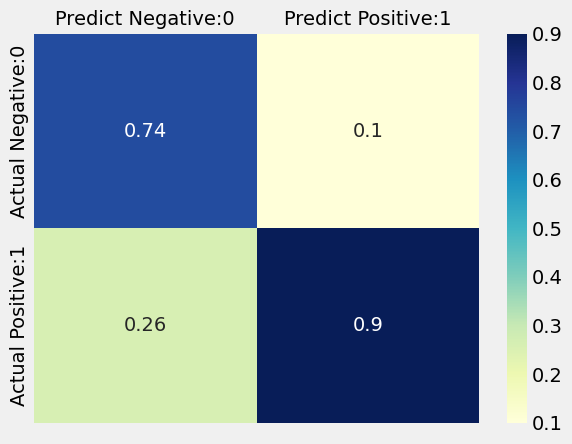

In [289]:
y_scores = lgbm_best_bayes.predict_proba(X_train)
y_scores = y_scores[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

precision = 0.9
threshold_precision = thresholds[np.argmax(precisions >= precision)]
y_train_pred = (y_scores >= threshold_precision)

print(classification_report(y_train, y_train_pred))
show_confusion_matrix(confusion_matrix(y_train, y_train_pred))

Este modelo alcançou 90% de identificações corretas ao custo de aumentar um pouco a taxa de falsos positivos. O modelo de regressão logística alcançou 6.7% de falsos positivos, este teve 10%.

Vejamos a precisão do modelo com dados que ele nunca viu.

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: num_estimators
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] feature_fraction is set=0.38099999999999995, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38099999999999995
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.22099999999999997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22099999999999997
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86       828
         1.0       0.94      0.10      0.18       299

    accuracy                           0.76      1127
   macro avg       0.85      0.55      0.52    

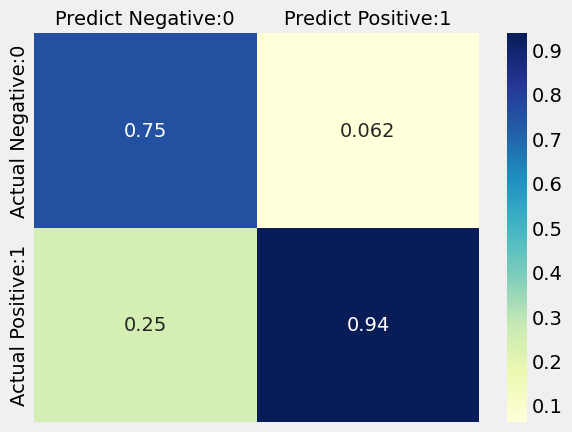

In [290]:
y_probas = lgbm_best_bayes.predict_proba(X_test)
y_scores = y_probas[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

precision = 0.9
threshold_precision = thresholds[np.argmax(precisions >= precision)]
y_train_pred = (y_scores >= threshold_precision)

print(classification_report(y_test, y_train_pred))
show_confusion_matrix(confusion_matrix(y_test, y_train_pred))

No conjunto de teste houve um aumento da taxa de verdadeiros negativos de 74% para 75% e também de verdadeiros positivos, de 90% para 94%.

**Conclusão:** Isso faz com que o modelo LGBMClassifier seja o melhor.